In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import pandas as pd
import collections
from scipy.stats import beta, t
from numpy import random
%matplotlib inline


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
n = 500

In [ ]:
np.random.seed(100)
x = np.float32(np.linspace(0,10,n))
error = np.random.standard_t(2,n)
y = 3*np.cos(x)-5*np.power((x/15),2)+error
y=np.float32(y)

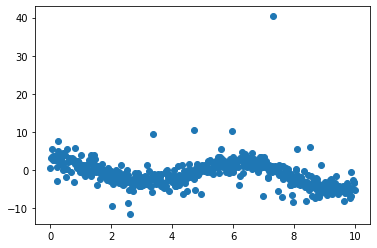

In [ ]:
plt.scatter(x,y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
X = x.reshape(-1,1)
Y = y.reshape(-1,1)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
X = torch.FloatTensor(X).to(device)
Y = torch.FloatTensor(Y).to(device)
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [ ]:
trainloader = DataLoader(X_train)
testloader = DataLoader(X_test)

In [ ]:
class Model(nn.Module):
  '''
  one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: 
  (i) number of hidden layers equals one; and 
  (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.
  '''
  def __init__(self, in_features=1, h1=10, h2=10, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)    # input layer
    self.fc2 = nn.Linear(h1, h2)            # hidden layer
    self.out = nn.Linear(h2, out_features)  # output layer
        
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

  def training_step(self, x, y):
    pass

  def validation_step(self, x, y):
    pass
  
  def validation_epoch_end(self, outputs):
    pass
  
  def epoch_end(self, epoch, result):
    pass

In [ ]:

class ModelTrainer():
  def fit(self, epochs=500, learning_rate=0.01, model=Model(),X_train=X_train,y_train=y_train,criterion = nn.MSELoss(), opt_func=torch.optim.Adam,seed=torch.manual_seed(4)):
    optimizer = opt_func(model.parameters(), learning_rate)

    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

  def _evaluate(self, model, X_test, y_test,criterion = nn.MSELoss()):
    with torch.no_grad():
      y_val = model.forward(X_test)
      loss = criterion(y_val, y_test)
    return [loss,y_val]



In [ ]:
best = []
for i in range(2,30):
  for j in range(2,30):
    model = Model(h1=i,h2=j).to(device)
    model_trainer = ModelTrainer()
    model_trainer.fit(500,0.01,model, X_train, y_train)
    best.append([i,j,model_trainer._evaluate(model,X_test,y_test)[0].to('cpu')])
  

KeyboardInterrupt: ignored

In [ ]:
plt.scatter(pd.DataFrame(best)[0],pd.DataFrame(best)[2],label='line1')

In [ ]:
pd.DataFrame(best)[(pd.DataFrame(best)[2]==min(pd.DataFrame(best)[2]))]

,0,1,2
456,18,10,tensor(3.6639)


In [ ]:
model = Model(h1=8,h2=29).to(device)
model_trainer = ModelTrainer()
model_trainer.fit(500,0.01,model, X_train, y_train)
y_val = model_trainer._evaluate(model,X,Y)[1]

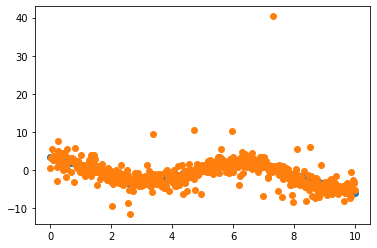

In [ ]:
plt.scatter(X.to('cpu'),y_val.to('cpu'),label='line1')
plt.scatter(X.to('cpu'),Y.to('cpu'),label='line2')

In [ ]:
np.random.seed(100)
x = np.float32(np.linspace(0,10,n))
error = np.random.standard_t(2,n)
yori = 3*np.cos(x)-5*np.power((x/15),2)
y = 3*np.cos(x)-5*np.power((x/15),2)+error
y=np.float32(y)

In [ ]:
x0 = x.reshape(-1,1)
x = x.reshape(-1,1)
y0 = y.reshape(-1,1)
y = y.reshape(-1,1)
dat = np.concatenate([x,y],axis=1)
x0 = torch.FloatTensor(x0).to(device)
y0 = torch.FloatTensor(y0).to(device)

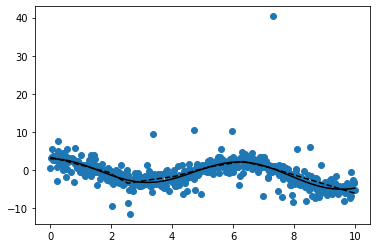

In [ ]:
plt.scatter(x0.to('cpu'),y0.to('cpu'))
plt.plot(x0.to('cpu'),yori,'k-')
plt.plot(x0.to('cpu'),y_val.to('cpu'),'k--')
#plt.ylim([-10,10])

In [ ]:
B=2000
out = []
inbag = np.zeros((len(y), B))
for i in range(B):
  r = random.choice(500,500,replace=True)
  y = dat[r][:,1].reshape(-1,1)
  x = dat[r][:,0].reshape(-1,1)
  x = torch.FloatTensor(x).to(device)
  y = torch.FloatTensor(y).to(device)
  bootstrap_count = collections.Counter(r)
  inbag[list(bootstrap_count.keys()),i]=list(bootstrap_count.values())

  model_trainer.fit(500,0.01,model, x, y)
  y_val = model_trainer._evaluate(model,x0,y0)[1]
  y_val = [y_val[i][0].to('cpu') for i in range(500)]
  out.append(y_val)

KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame(out).astype('float').to_csv('infinitesimaljackknife_out.csv')
pd.DataFrame(inbag).astype('float').to_csv('inbag_matrix')
from google.colab import files
files.download('infinitesimaljackknife_out.csv')
files.download('inbag_matrix.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pred = (pd.DataFrame(out).astype('float').T).to_numpy()

In [ ]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pred = pd.read_csv('infinitesimaljackknife_out.csv',index_col=0).T
inbag = pd.read_csv('inbag_matrix.csv',index_col=0)

In [ ]:
pred_mean = np.mean(pred, 0)
pred_centered = pred - pred_mean

In [ ]:
B=2000
V_IJ = np.sum((np.dot(inbag - 1, (pred_centered).T)/B)**2,0)

{'boxes': [<matplotlib.lines.Line2D at 0x7fd1d0c96550>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd1d0c9c610>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd1d0ca3650>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd1d0ca3110>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd1d0c96b50>,
  <matplotlib.lines.Line2D at 0x7fd1d0c9c0d0>]}

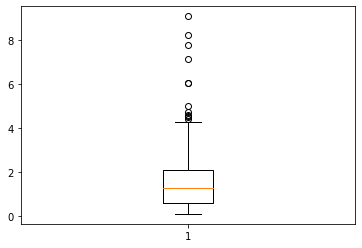

In [ ]:
plt.boxplot(V_IJ)

In [ ]:
n_var = np.mean(
np.square(inbag[0:B]).mean(axis=1).T.view()
- np.square(inbag[0:B].mean(axis=1)).T.view()
)

In [ ]:
boot_var = np.square(pred_centered).sum(axis=1) / B
n_train_samples = inbag.shape[0]

In [ ]:
bias_correction = n_train_samples * n_var * boot_var / B

In [ ]:
V_uij = V_IJ-bias_correction

In [ ]:
np.sum(V_uij>0)

324

{'boxes': [<matplotlib.lines.Line2D at 0x7fd1d0c091d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd1d0c0d290>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd1d0c142d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd1d0c0dd50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd1d0c097d0>,
  <matplotlib.lines.Line2D at 0x7fd1d0c09d10>]}

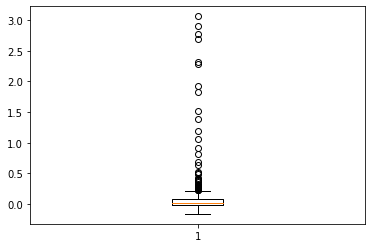

In [ ]:
plt.boxplot(V_uij)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<ErrorbarContainer object of 3 artists>

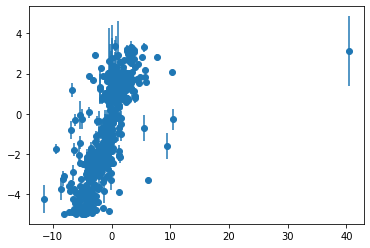

In [ ]:
plt.errorbar(y0.to('cpu').numpy(), np.mean(pred, 1), yerr=np.sqrt(V_uij), fmt='o')
#plt.plot([0, 10], [0, 40], 'k--')
#plt.xlabel('True Y')
#plt.ylabel('Predicted Y')
#plt.show()

In [ ]:
len(np.mean(pred, 1))
len(y0.to('cpu').numpy())

500

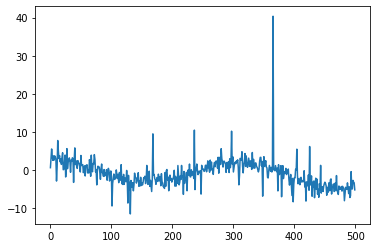

In [ ]:
plt.plot(y0.to('cpu').numpy())

In [ ]:
upper = y_val.to('cpu').numpy().T[0] + 1.96*V_uij
lower = y_val.to('cpu').numpy().T[0] - 1.96*V_uij

(-10.0, 10.0)

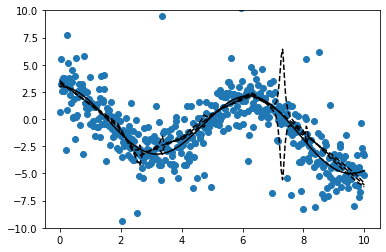

In [ ]:
plt.scatter(x0.to('cpu'),y0.to('cpu'))
plt.plot(x0.to('cpu'),yori,'k-')
plt.plot(x0.to('cpu'),y_val.to('cpu'),'k--')
plt.plot(x0.to('cpu'),upper,'k--')
plt.plot(x0.to('cpu'),lower,'k--')
plt.ylim([-10,10])

In [ ]:
sum(np.logical_and(yori < np.maximum(upper,lower),yori > np.minimum(upper,lower)))

112

In [ ]:
for col in c.columns:
  c[col] = c[col].sort_values().reset_index()[col]

AttributeError: ignored

In [ ]:
CB80 = c.iloc[500:4501,:]
CB90 = c.iloc[250:4751,:]

In [ ]:
coverage = []
for i in range(500):
  coverage.append(CB80.iloc[-1,i] > yori[i] and CB80.iloc[0,i] < yori[i])
cov80 = sum(coverage)/500
cov80

0.672

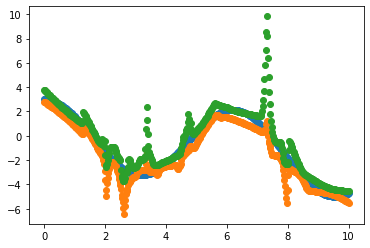

In [ ]:

plt.scatter(x0.to('cpu'),yori,label='line1')
plt.scatter(x0.to('cpu'),np.array(CB80.iloc[0,]),label='line2')
plt.scatter(x0.to('cpu'),np.array(CB80.iloc[-1,]),label='line2')

In [ ]:
coverage = []
for i in range(500):
  coverage.append(CB90.iloc[-1,i] > yori[i] and CB90.iloc[0,i] < yori[i])
cov90 = sum(coverage)/500
cov90

0.79

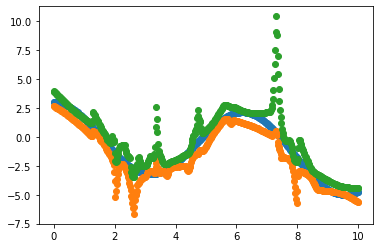

In [ ]:

plt.scatter(x0.to('cpu'),yori,label='line1')
plt.scatter(x0.to('cpu'),np.array(CB90.iloc[0,]),label='line2')
plt.scatter(x0.to('cpu'),np.array(CB90.iloc[-1,]),label='line2')

In [ ]:
CB = c.iloc[125:4876,:]


In [ ]:
coverage = []
for i in range(500):
  coverage.append(CB.iloc[-1,i] > yori[i] and CB.iloc[0,i] < yori[i])

In [ ]:
sum(coverage)/500

0.886

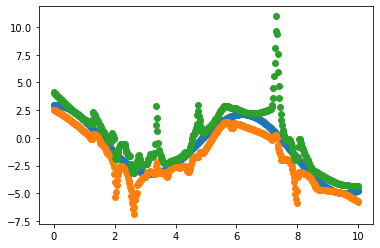

In [ ]:

plt.scatter(x0.to('cpu'),yori,label='line1')
plt.scatter(x0.to('cpu'),np.array(CB.iloc[0,]),label='line2')
plt.scatter(x0.to('cpu'),np.array(CB.iloc[-1,]),label='line2')